## Семинар 6: "Детекция объектов на изображении"

ФИО: Лапутин Фёдор Александрович

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели. 

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество). 
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 4 марта.


Для решения задачи детекции был выбран датасет футбольных мячей из [roboflow.com](https://universe.roboflow.com/)

In [1]:
import os
import math
import sys
from tqdm import tqdm
from pathlib import Path
import xml.etree.ElementTree as ET

import cv2
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import ToTensor
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from mean_average_precision import MetricBuilder

BASE_PATH = "Soccer ball.v1i.voc"


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.images = []
        self.targets = []
        self._get_paths()
        self.transform = transform

    def _parses_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find("size")
        width = int(size.find("width").text)
        height = int(size.find("height").text)
        bboxes = []
        names = []
        for obj in root.iter("object"):
            name = obj.find("name").text
            if name == "0":
                bndbox = obj.find("bndbox")
                xmin = int(bndbox.find("xmin").text)
                ymin = int(bndbox.find("ymin").text)
                xmax = int(bndbox.find("xmax").text)
                ymax = int(bndbox.find("ymax").text)
                bboxes.append([xmin, ymin, xmax, ymax])
                names.append(name)
        return bboxes, names, width, height

    def _get_paths(self):
        for path in os.listdir(self.dataset_path):
            path = Path(path)
            if path.suffix == ".xml":
                self.targets.append(os.path.join(self.dataset_path, path))
            else:
                self.images.append(os.path.join(self.dataset_path, path))
        self.images.sort()
        self.targets.sort()

    def __getitem__(self, idx):
        img_path = self.images[idx]
        target_path = self.targets[idx]

        img = Image.open(img_path).convert("RGB")
        img = np.array(img, dtype=np.float32)
        img /= 255.0

        bboxes, labels, width, height = self._parses_xml(target_path)

        target = {}
        target["boxes"] = torch.as_tensor(bboxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor([1 for x in labels], dtype=torch.int64)

        if self.transform:
            sample = {"image": img, "bboxes": bboxes, "labels": labels}
            sample = self.transform(**sample)
            img = sample["image"]

            if target["boxes"].shape[0] != 0:
                target["boxes"] = torch.stack(
                    tuple(map(torch.tensor, zip(*sample["bboxes"])))
                ).permute(1, 0)
            else:
                target["boxes"] = torch.zeros(0, 4)

        return (img, target)

    def __len__(self):
        return len(self.images)

In [3]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
)

test_transforms = A.Compose(
    [
        ToTensorV2(p=1.0),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
)


train_dataset = VOCDataset(
    dataset_path=os.path.join(BASE_PATH, "train"), transform=train_transforms
)
test_dataset = VOCDataset(
    dataset_path=os.path.join(BASE_PATH, "test"), transform=test_transforms
)


def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, drop_last=True
)

valid_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, drop_last=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


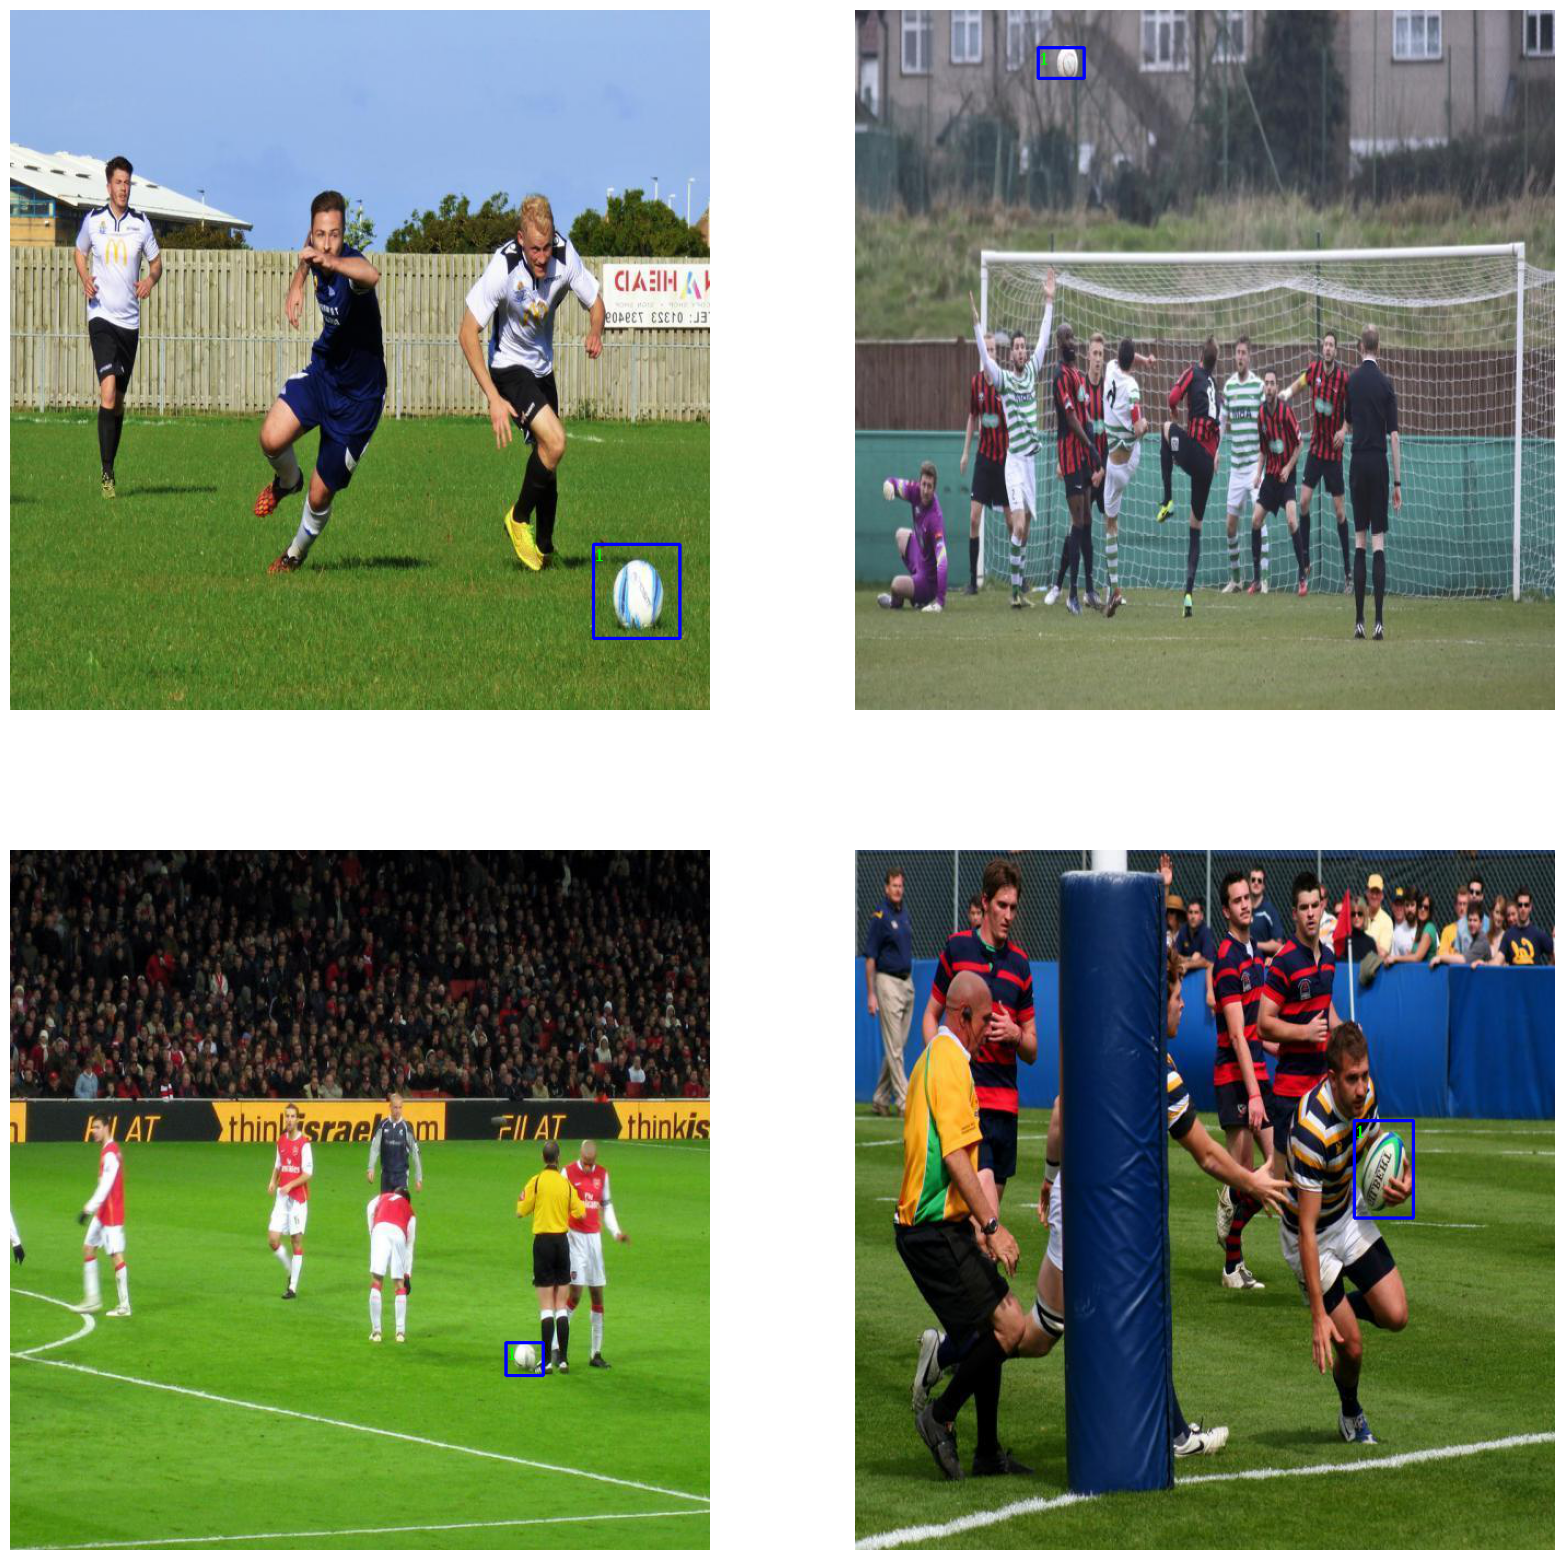

In [4]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images[:4])
targets = [{k: v.to(device) for k, v in t.items()} for t in targets[:4]]

plt.figure(figsize=(20, 20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2, 2, i + 1)
    boxes = targets[i]["boxes"].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1, 2, 0).cpu().numpy()
    names = targets[i]["labels"].cpu().numpy().astype(np.int64)
    for i, box in enumerate(boxes):
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 220), 2)
        cv2.putText(
            sample,
            str(names[i]),
            (box[0], box[1] + 15),
            cv2.FONT_HERSHEY_COMPLEX,
            0.5,
            (0, 220, 0),
            1,
            cv2.LINE_AA,
        )

    plt.axis("off")
    plt.imshow(sample)

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

c:\Users\laput\miniconda3\envs\pcb\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\laput\miniconda3\envs\pcb\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()

    running_loss = 0.0
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        if not math.isfinite(losses):
            print(f"Loss is {losses}, stopping training")
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch} train loss: {epoch_loss}")
    return epoch_loss


def validation_epoch(model, data_loader, device, epoch):
    running_loss = 0.0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]

        with torch.no_grad():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch} test loss: {epoch_loss}")
    return epoch_loss


def evaluate(model, data_loader, device, iou_thresholds=0.5):
    metric_fn = MetricBuilder.build_evaluation_metric(
        "map_2d", async_mode=True, num_classes=1
    )
    model.eval()
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = list(image.to(device) for image in images)
            predictions = model(images)

            for pred, gt in zip(predictions, targets):
                formatted_preds = list(
                    map(
                        lambda x: x[0].tolist() + [0] + [float(x[1])],
                        zip(pred["boxes"], pred["scores"]),
                    )
                )
                formatted_gt = list(map(lambda x: x.tolist() + [0, 0, 0], gt["boxes"]))
                metric_fn.add(np.array(formatted_preds), np.array(formatted_gt))

    return metric_fn.value(iou_thresholds=iou_thresholds)["mAP"]

In [7]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_data_loader, device, epoch)
    lr_scheduler.step()
    validation_epoch(model, valid_data_loader, device=device, epoch=epoch)
    print(f"mAP@: {evaluate(model, valid_data_loader, device, iou_thresholds=0.5)}")

100%|██████████| 288/288 [01:55<00:00,  2.50it/s]


Epoch 0 train loss: 0.1789334139608561
Epoch 0 test loss: 0.16207239487530073


100%|██████████| 13/13 [00:02<00:00,  4.97it/s]


mAP@: 0.8086246252059937


100%|██████████| 288/288 [02:06<00:00,  2.27it/s]


Epoch 1 train loss: 0.16175637184561018
Epoch 1 test loss: 0.15340262106313815


100%|██████████| 13/13 [00:02<00:00,  5.08it/s]


mAP@: 0.8467154502868652


100%|██████████| 288/288 [02:09<00:00,  2.23it/s]


Epoch 2 train loss: 0.15890879601743782
Epoch 2 test loss: 0.15521224544777648


100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


mAP@: 0.8345723748207092


100%|██████████| 288/288 [02:11<00:00,  2.19it/s]


Epoch 3 train loss: 0.1361998515186752
Epoch 3 test loss: 0.16315618068745985


100%|██████████| 13/13 [00:02<00:00,  4.86it/s]


mAP@: 0.9052891731262207


100%|██████████| 288/288 [02:11<00:00,  2.18it/s]


Epoch 4 train loss: 0.12909362442790986
Epoch 4 test loss: 0.1672663120017697


100%|██████████| 13/13 [00:02<00:00,  4.87it/s]


mAP@: 0.8862296938896179


100%|██████████| 288/288 [02:12<00:00,  2.18it/s]


Epoch 5 train loss: 0.12303249908090651
Epoch 5 test loss: 0.16228949882297675


100%|██████████| 13/13 [00:02<00:00,  4.89it/s]


mAP@: 0.8934585452079773


100%|██████████| 288/288 [01:54<00:00,  2.50it/s]


Epoch 6 train loss: 0.11238045595471699
Epoch 6 test loss: 0.1624421089823288


100%|██████████| 13/13 [00:02<00:00,  6.11it/s]


mAP@: 0.8929259181022644


100%|██████████| 288/288 [01:41<00:00,  2.83it/s]


Epoch 7 train loss: 0.11132046842252362
Epoch 7 test loss: 0.1599562722947587


100%|██████████| 13/13 [00:01<00:00,  6.50it/s]


mAP@: 0.9040489792823792


100%|██████████| 288/288 [02:07<00:00,  2.25it/s]


Epoch 8 train loss: 0.11013776916721259
Epoch 8 test loss: 0.164092931617484


100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


mAP@: 0.8951898813247681


100%|██████████| 288/288 [02:12<00:00,  2.17it/s]


Epoch 9 train loss: 0.10899736411384287
Epoch 9 test loss: 0.16068211470697216


100%|██████████| 13/13 [00:02<00:00,  4.91it/s]

mAP@: 0.8985468745231628


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


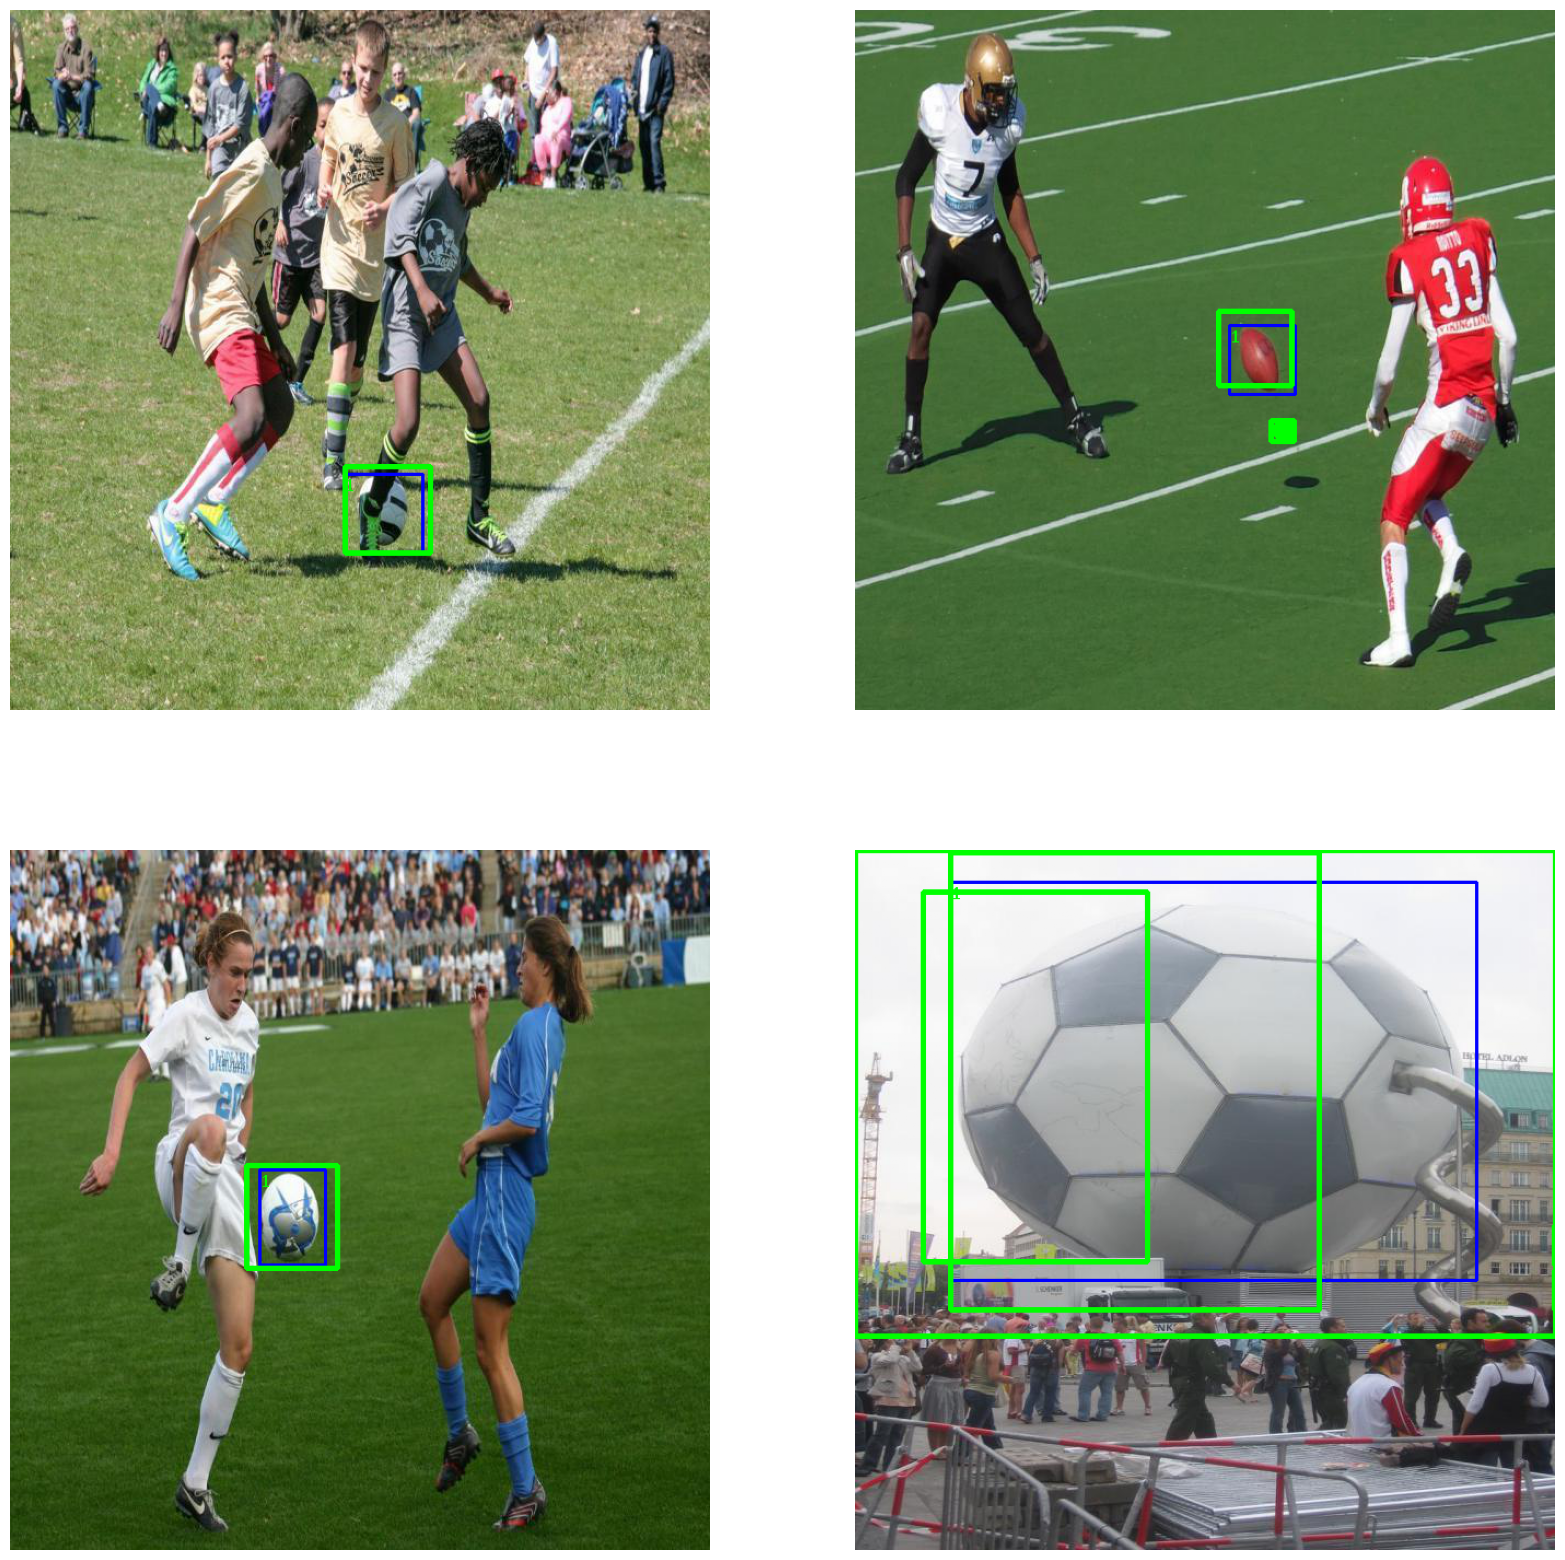

In [15]:
images, targets = next(iter(valid_data_loader))
images = list(image.to(device) for image in images[:4])

model.eval()
with torch.no_grad():
    predictions = model(images)

targets = [{k: v.to(device) for k, v in t.items()} for t in targets[:4]]

plt.figure(figsize=(20, 20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2, 2, i + 1)
    boxes = targets[i]["boxes"].cpu().numpy().astype(np.int32)
    pred_boxes = predictions[i]["boxes"].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1, 2, 0).cpu().numpy()
    names = targets[i]["labels"].cpu().numpy().astype(np.int64)
    for i, box in enumerate(boxes):
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 220), 2)
        cv2.putText(
            sample,
            str(names[i]),
            (box[0], box[1] + 15),
            cv2.FONT_HERSHEY_COMPLEX,
            0.5,
            (0, 220, 0),
            1,
            cv2.LINE_AA,
        )
    for box in pred_boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 220, 0), 3)

    plt.axis("off")
    plt.imshow(sample)

Выводы:
- Модель досточно быстро ушла в плато.
- Есть неточности в дектеции футбольных мячей, как, например, в случае с огромным мячем сверху и артефакт у регбистов.
- Следует более точно настроить шедулер, а также выбрать оптимальное число слоев для заморозки весов.